In [82]:
pip install pandas scikit-learn openpyxl matplotlib seaborn numpy==1.26.0 statsmodels catboost

Note: you may need to restart the kernel to use updated packages.


In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [84]:
df = pd.read_excel("train.xlsx")  
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


In [85]:
df.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [86]:
 # Преобразуем колонку с датой в формат datetime
df['dt'] = pd.to_datetime(df['dt'])

# Убеждаемся, что данные отсортированы по времени
df = df.sort_values(by='dt')


# Добавляем новые признаки
df["year"] = df["dt"].dt.year
df["month"] = df["dt"].dt.month
df["quarter"] = df["dt"].dt.quarter
df["day_of_month"] = df["dt"].dt.day
df["day_of_week"] = df["dt"].dt.weekday 

df = df.copy()


In [87]:
df.set_index('dt', inplace=True)

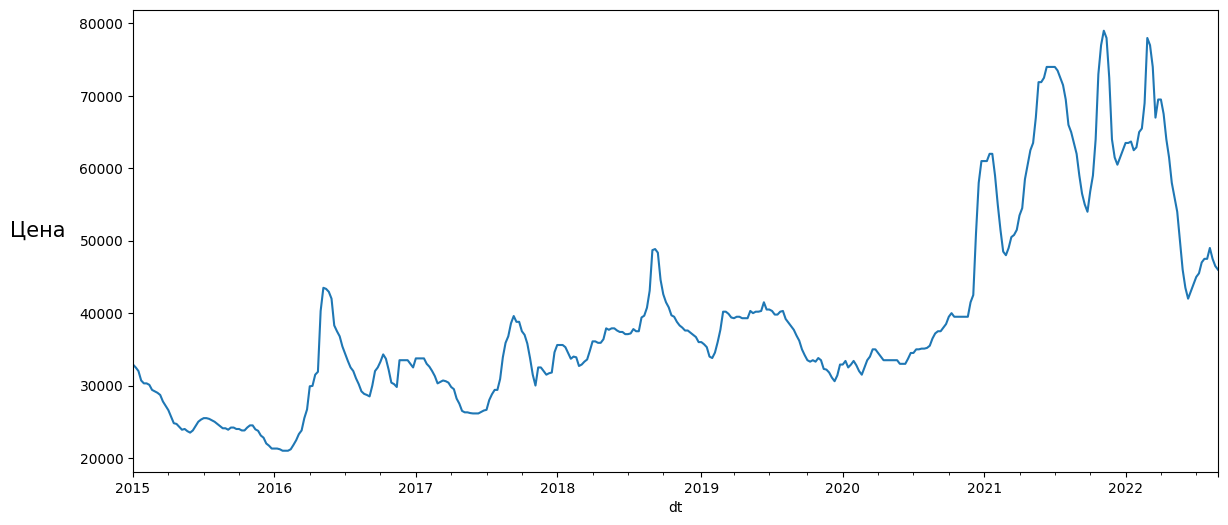

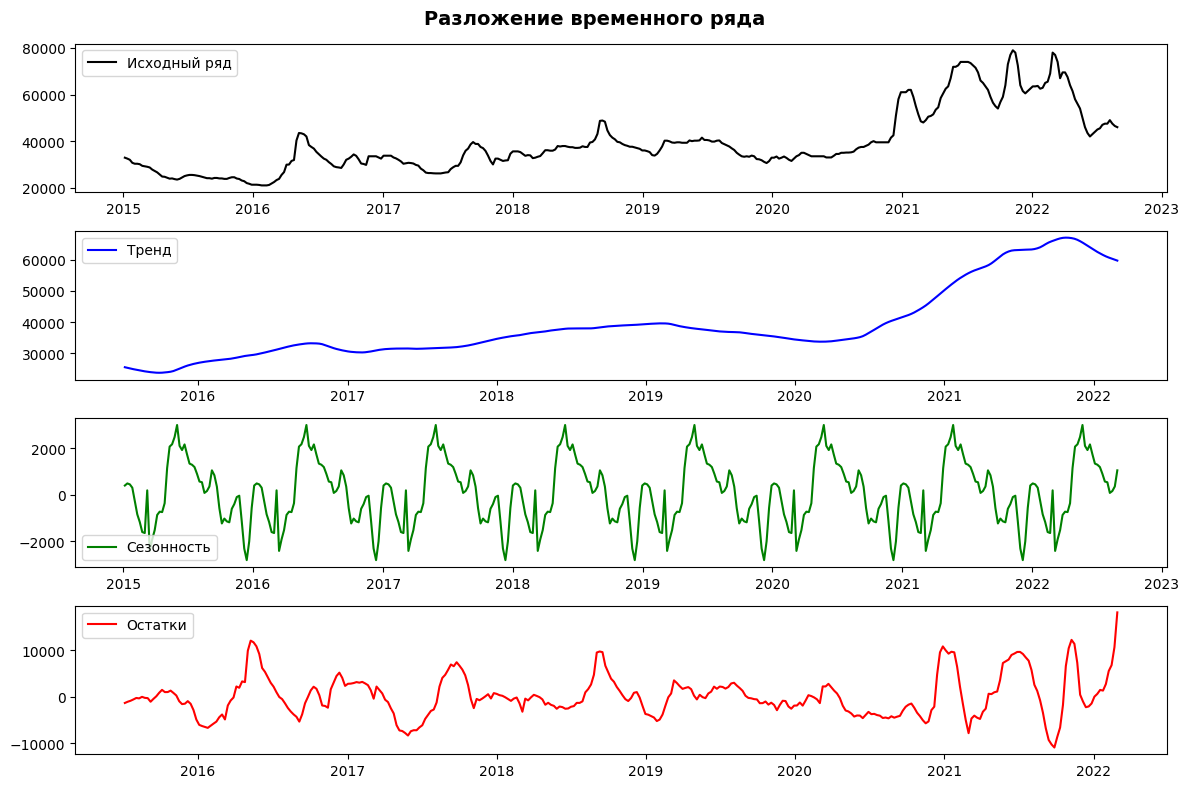

In [88]:
# Разложение временного ряда
decomposition = seasonal_decompose(df['Цена на арматуру'], model='additive', period=52)  # период ~1 год



# Рассмотрим изменение цены
plt.figure(figsize=(14, 6))
# plt.title('Time series example')
# plt.xlabel('Date', fontsize=15)
plt.ylabel('Цена', rotation=0, labelpad=30, fontsize=15)
df['Цена на арматуру'].plot();

plt.figure(figsize=(12, 8))
plt.suptitle("Разложение временного ряда", fontsize=14, fontweight='bold')

plt.subplot(4, 1, 1)
plt.plot(df['Цена на арматуру'], label='Исходный ряд', color='black')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Тренд', color='blue')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Сезонность', color='green')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Остатки', color='red')
plt.legend()

plt.tight_layout()
plt.show()

In [89]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series):
    """
    Функция для проверки стационарности временного ряда с помощью теста Дики-Фуллера.
    
   
    """
    result = adfuller(series.dropna())  # Тест ADF, удаляем NaN перед проверкой
    print("Результаты теста Дики-Фуллера:")
    print(f"ADF-статистика: {result[0]:.4f}")
    print(f"p-значение: {result[1]:.4f}")
    print("Критические значения:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    
    # Интерпретация результатов
    if result[1] <= 0.05:
        print("\n✅ Ряд стационарен (отвергаем нулевую гипотезу о наличии единичного корня).")
    else:
        print("\n❌ Ряд НЕ стационарен (не отвергаем нулевую гипотезу).")

# Проверяем стационарность исходного ряда
test_stationarity(df['Цена на арматуру'])


Результаты теста Дики-Фуллера:
ADF-статистика: -1.9259
p-значение: 0.3200
Критические значения:
   1%: -3.4471
   5%: -2.8689
   10%: -2.5707

❌ Ряд НЕ стационарен (не отвергаем нулевую гипотезу).


In [95]:
import numpy as np
import pandas as pd

# Определяем окно скользящего стандартного отклонения
window = 12  # Например, 12 для месячных данных

# Копируем данные, чтобы не изменять оригинальный DataFrame
df_transformed = df.copy()

# Вычисляем скользящее стандартное отклонение
df_transformed['rolling_std'] = df_transformed['Цена на арматуру'].rolling(window=window).std()

# Нормализуем ряд, деля на скользящее стандартное отклонение
df_transformed['normalized_price'] = df_transformed['Цена на арматуру'] / df_transformed['rolling_std']

# Логарифмируем нормализованный ряд (добавляем небольшую константу, чтобы избежать log(0))
df_transformed['log_normalized_price'] = np.log(df_transformed['normalized_price'] + 1e-10)

# Дифференцируем логарифмированный ряд
df_transformed['stationary_price'] = df_transformed['log_normalized_price'].diff()

# Удаляем пропущенные значения, возникшие после вычислений
df_transformed = df_transformed.dropna()

# Выводим обработанный DataFrame
df_transformed


,Цена на арматуру,year,month,quarter,day_of_month,day_of_week,rolling_std,normalized_price,log_normalized_price,stationary_price
dt,,,,,,,,,,
2015-09-14,24200,2015,9,3,14,0,610.700045,39.626655,3.679502,-0.029897
2015-09-21,24200,2015,9,3,21,0,607.279078,39.849883,3.685119,0.005617
2015-09-28,24000,2015,9,3,28,0,577.547060,41.555055,3.727019,0.041900
2015-10-05,24000,2015,10,4,5,0,514.045158,46.688505,3.843498,0.116479
2015-10-12,23800,2015,10,4,12,0,443.129368,53.708921,3.983579,0.140081
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,47500,2022,8,3,1,0,3320.049288,14.307017,2.660750,0.271592
2022-08-08,49000,2022,8,3,8,0,2461.829820,19.903894,2.990915,0.330165
2022-08-15,47500,2022,8,3,15,0,2165.063509,21.939310,3.088280,0.097365


In [96]:
from statsmodels.tsa.stattools import adfuller

# Применяем тест Дики-Фуллера к преобразованному ряду
result = adfuller(df_transformed['normalized_price'])

# Выводим результаты теста
print("Результаты теста Дики-Фуллера:")
print(f"ADF-статистика: {result[0]:.4f}")
print(f"p-значение: {result[1]:.4f}")
print("Критические значения:")
for key, value in result[4].items():
    print(f"   {key}: {value:.4f}")

# Интерпретация результата
if result[1] < 0.05:
    print("\n✅ Временной ряд стационарен (отклоняем нулевую гипотезу).")
else:
    print("\n❌ Временной ряд не является стационарным (не можем отклонить нулевую гипотезу).")


Результаты теста Дики-Фуллера:
ADF-статистика: -5.0742
p-значение: 0.0000
Критические значения:
   1%: -3.4486
   5%: -2.8696
   10%: -2.5711

✅ Временной ряд стационарен (отклоняем нулевую гипотезу).


In [97]:
df_transformed.to_csv("stdanie.csv", index=True)

In [93]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [100]:
# Загрузка данных
df = pd.read_csv('danie.csv', parse_dates=['dt'], index_col='dt')

# Выбор целевой переменной
target = df['Цена на арматуру'].dropna()

# Проверка стационарности (например, с помощью теста Дики-Фуллера)
from statsmodels.tsa.stattools import adfuller
result = adfuller(target)
print(f"ADF p-value: {result[1]:.4f}")  # Если p-value > 0.05, ряд нестационарен

ADF p-value: 0.0000


0:	learn: 0.0919476	test: 0.0631353	best: 0.0631353 (0)	total: 1.35ms	remaining: 1.35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.04158022267
bestIteration = 47

Shrink model to first 48 iterations.
MAE: 0.03
MSE: 0.00
RMSE: 0.04
R²: 0.6148


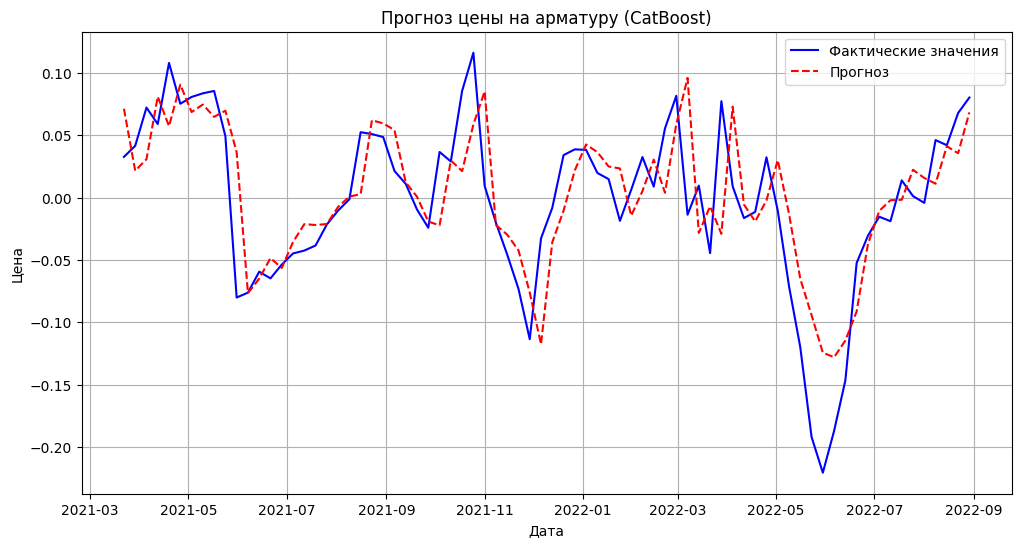

In [101]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

# Предполагаем, что у нас уже есть DataFrame df с данными

# Подготовка данных
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['quarter'] = df.index.quarter 

for lag in [1, 2, 3, 6, 12]:
    df[f'lag_{lag}'] = df['Цена на арматуру'].shift(lag)

# Выбор признаков и целевой переменной
features = ['year', 'month', 'day', 'quarter', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12']
target = 'Цена на арматуру'

# Разделение на обучающую и тестовую выборки
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Создание и обучение модели
model = CatBoostRegressor(iterations=1000, 
                          learning_rate=0.1, 
                          depth=6, 
                          loss_function='RMSE',
                          verbose=200)

model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          early_stopping_rounds=50)

# Прогнозирование
predictions = model.predict(X_test)

# Оценка модели
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Фактические значения', color='blue')
plt.plot(test.index, predictions, label='Прогноз', color='red', linestyle='--')
plt.title('Прогноз цены на арматуру (CatBoost)')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()
